In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import models
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64

# Fashion MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# FASHION

In [ ]:
train_dataset = datasets.FashionMNIST(root='mnist_data/', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.FashionMNIST(root='mnist_data/', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

### VAE

In [2]:
lr = 5e-4
num_epochs = 25
latent_dims = 10


vae = models.VAE(latent_size=latent_dims)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vae.parameters()), lr=lr)
criterion_ae = nn.MSELoss()


total_step = len(train_loader)
for epoch in range(num_epochs):
    for images, _ in train_loader:
        images = images.to(device)

        # Forward pass through CAE
        reconstructions = vae(images)

        # Compute CAE loss
        loss = criterion_ae(reconstructions, images)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], AE Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/25], AE Loss: 0.0824
Epoch [2/25], AE Loss: 0.0648
Epoch [3/25], AE Loss: 0.0617
Epoch [4/25], AE Loss: 0.0543
Epoch [5/25], AE Loss: 0.0558
Epoch [6/25], AE Loss: 0.0516
Epoch [7/25], AE Loss: 0.0505
Epoch [8/25], AE Loss: 0.0488
Epoch [9/25], AE Loss: 0.0552
Epoch [10/25], AE Loss: 0.0616
Epoch [11/25], AE Loss: 0.0469
Epoch [12/25], AE Loss: 0.0503
Epoch [13/25], AE Loss: 0.0590
Epoch [14/25], AE Loss: 0.0398
Epoch [15/25], AE Loss: 0.0484
Epoch [16/25], AE Loss: 0.0485
Epoch [17/25], AE Loss: 0.0439
Epoch [18/25], AE Loss: 0.0471
Epoch [19/25], AE Loss: 0.0446
Epoch [20/25], AE Loss: 0.0392
Epoch [21/25], AE Loss: 0.0441
Epoch [22/25], AE Loss: 0.0552
Epoch [23/25], AE Loss: 0.0460
Epoch [24/25], AE Loss: 0.0409
Epoch [25/25], AE Loss: 0.0499


In [3]:
vae.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (mu): Linear(in_features=3136, out_features=10, bias=True)
  (logvar): Linear(in_features=3136, out_features=10, bias=True)
  (upsample): Linear(in_features=10, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  )
)

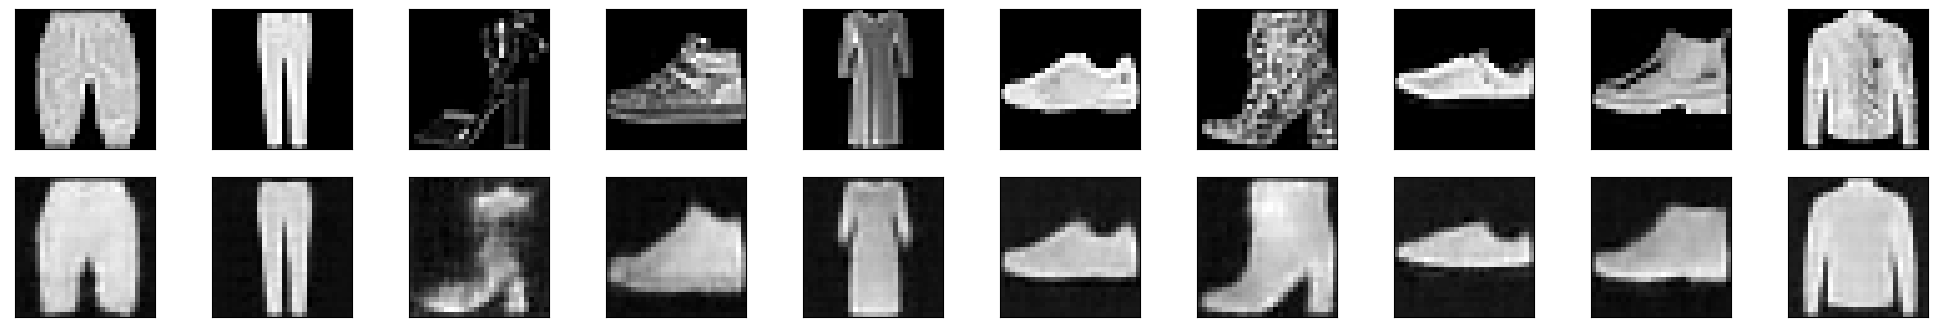

In [5]:
# plot the first ten input images and then reconstructed images
fig = plt.figure(figsize=(25,4))

# input images on top row, reconstructions on bottom
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(example_data[i].view(28, 28), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,10,i+11)
    plt.imshow(vae.decode(vae.encode((example_data[i]))).detach().view(28, 28), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [7]:
# Save the models
torch.save(vae.state_dict(), 'models/fashion/vae.pth')


### CNN

In [2]:
def train_model(num_epochs,model,train_loader,test_loader,learning_rate,device="cpu"):
    class_names = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_func = nn.CrossEntropyLoss()

    model.train()
    for epoch in tqdm(range(num_epochs)):
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            loss = loss_func(model(x), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    correct_pred = {name: 0 for name in class_names}
    total_pred = {name: 0 for name in class_names}

    model.eval()
    for x, y in test_loader:
        images, labels = x.to(device), y.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1

    for name, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[name]
        print("Accuracy for class {} is: {:.1f} %".format(name, accuracy))

In [3]:
#PARAMETERS
learning_rate=1e-3
num_epochs=20

conv_net = models.CNN()
train_model(num_epochs,conv_net,train_loader,test_loader,learning_rate)


Accuracy for class 0 is: 85.5 %
Accuracy for class 1 is: 96.0 %
Accuracy for class 2 is: 82.9 %
Accuracy for class 3 is: 86.6 %
Accuracy for class 4 is: 82.1 %
Accuracy for class 5 is: 97.1 %
Accuracy for class 6 is: 54.4 %
Accuracy for class 7 is: 94.7 %
Accuracy for class 8 is: 97.3 %
Accuracy for class 9 is: 94.8 %


In [5]:
examples = enumerate(train_loader)
batch_idx, (example_data, _) = next(examples)

In [12]:
#IMPORTANT: how to handle single images
#preds = conv_net(example_data[0].reshape(-1,1,28,28))


In [22]:
# Save the models
torch.save(conv_net.state_dict(), 'models/fashion/cnn.pth')


# DIGITS

In [23]:
train_dataset = datasets.MNIST(root='mnist_data/', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = datasets.MNIST(root='mnist_data/', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

### VAE

In [24]:
lr = 5e-4
num_epochs = 25
latent_dims = 10


vae = models.VAE(latent_size=latent_dims)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, vae.parameters()), lr=lr)
criterion_ae = nn.MSELoss()


total_step = len(train_loader)
for epoch in range(num_epochs):
    for images, _ in train_loader:
        images = images.to(device)

        # Forward pass through CAE
        reconstructions = vae(images)

        # Compute CAE loss
        loss = criterion_ae(reconstructions, images)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], AE Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/25], AE Loss: 0.0815
Epoch [2/25], AE Loss: 0.0678
Epoch [3/25], AE Loss: 0.0608
Epoch [4/25], AE Loss: 0.0563
Epoch [5/25], AE Loss: 0.0498
Epoch [6/25], AE Loss: 0.0389
Epoch [7/25], AE Loss: 0.0578
Epoch [8/25], AE Loss: 0.0404
Epoch [9/25], AE Loss: 0.0514
Epoch [10/25], AE Loss: 0.0463
Epoch [11/25], AE Loss: 0.0589
Epoch [12/25], AE Loss: 0.0448
Epoch [13/25], AE Loss: 0.0517
Epoch [14/25], AE Loss: 0.0535
Epoch [15/25], AE Loss: 0.0436
Epoch [16/25], AE Loss: 0.0568
Epoch [17/25], AE Loss: 0.0541
Epoch [18/25], AE Loss: 0.0448
Epoch [19/25], AE Loss: 0.0392
Epoch [20/25], AE Loss: 0.0363
Epoch [21/25], AE Loss: 0.0409
Epoch [22/25], AE Loss: 0.0468
Epoch [23/25], AE Loss: 0.0536
Epoch [24/25], AE Loss: 0.0527
Epoch [25/25], AE Loss: 0.0424


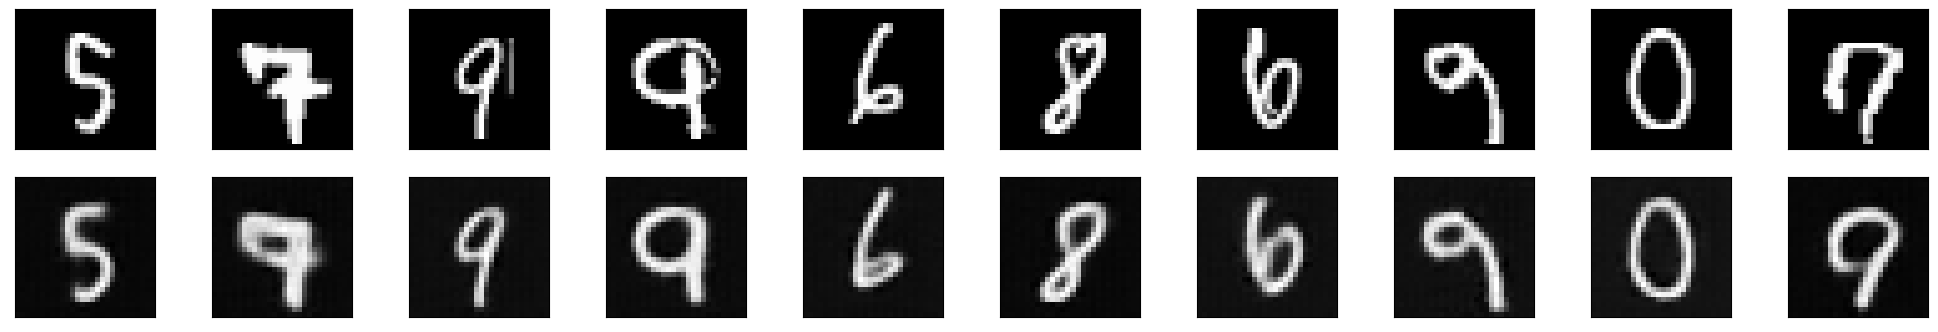

In [27]:
examples = enumerate(train_loader)
batch_idx, (example_data, _) = next(examples)

# plot the first ten input images and then reconstructed images
fig = plt.figure(figsize=(25,4))

# input images on top row, reconstructions on bottom
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(example_data[i].view(28, 28), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,10,i+11)
    plt.imshow(vae.decode(vae.encode((example_data[i]))).detach().view(28, 28), cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [28]:
# Save the models
torch.save(vae.state_dict(), 'models/digits/vae.pth')

### CNN

In [29]:
#PARAMETERS
learning_rate=1e-3
num_epochs=10

conv_net = models.CNN()
train_model(num_epochs,conv_net,train_loader,test_loader,learning_rate)


Accuracy for class 0 is: 99.5 %
Accuracy for class 1 is: 98.6 %
Accuracy for class 2 is: 99.1 %
Accuracy for class 3 is: 98.4 %
Accuracy for class 4 is: 98.3 %
Accuracy for class 5 is: 98.7 %
Accuracy for class 6 is: 98.5 %
Accuracy for class 7 is: 97.9 %
Accuracy for class 8 is: 99.0 %
Accuracy for class 9 is: 97.8 %


In [30]:
# Save the models
torch.save(conv_net.state_dict(), 'models/digits/cnn.pth')